In [16]:
import torch 
import lightning
import numpy as np

from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward, Normalization

class TBGCV(BaseCV, lightning.LightningModule):
    BLOCKS = ["norm_in", "encoder",]
    def __init__(
        self,
        encoder_layers: list,
        options: dict = None,
        **kwargs,
    ):
        super().__init__(in_features=encoder_layers[0], out_features=encoder_layers[-1], **kwargs)
        # ======= OPTIONS =======
        options = self.parse_options(options)
        self.cv_normalize = False
        self.cv_min = 0
        self.cv_max = 1
        
        # ======= BLOCKS =======
        # initialize norm_in
        o = "norm_in"
        if (options[o] is not False) and (options[o] is not None):
            self.norm_in = Normalization(self.in_features, **options[o])

        # initialize encoder
        o = "encoder"
        self.encoder = FeedForward(encoder_layers, **options[o])

    def forward_cv(self, x: torch.Tensor) -> torch.Tensor:
        """Evaluate the CV without pre or post/processing modules."""
        
        if self.norm_in is not None:
            x = self.norm_in(x)
        x = self.encoder(x)
        
        if self.cv_normalize:
            x = self._map_range(x)
        
        # x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x

    def set_cv_range(self, cv_min, cv_max, cv_std):
        self.cv_normalize = True
        self.cv_min = cv_min
        self.cv_max = cv_max
        self.cv_std = cv_std

    def _map_range(self, x):
        out_max = 1
        out_min = -1
        return (x - self.cv_min) * (out_max - out_min) / (self.cv_max - self.cv_min) + out_min

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_cv(x)
        
        return x

In [10]:
encoder_layers = [30, 100, 100, 2]
options = {
    "encoder": {
        "activation": "tanh",
        "dropout": [0.5, 0.5, 0.5]
    },
    "norm_in": {
    },
}
tbgcv = TBGCV(
    encoder_layers=encoder_layers,
    options=options
)

In [11]:
ckpt_path = "../res/0610_121601/model/mlcv-final.pt"
ckpt = torch.load(ckpt_path)
tbgcv.load_state_dict(ckpt)

<All keys matched successfully>

In [19]:
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]

tbgcv.eval()
data_dir = f"../../../simulation/data/alanine"
projection_dataset = torch.load(f"{data_dir}/uniform-xyz-aligned.pt")
projection_dataset = projection_dataset[:, ALANINE_HEAVY_ATOM_IDX].reshape(projection_dataset.shape[0], -1)
c5_state = torch.load(f"../../../simulation/data/alanine/c5.pt")['xyz'].to(tbgcv.device)
psi_list = np.load(f"{data_dir}/uniform-psi.npy")
phi_list = np.load(f"{data_dir}/uniform-phi.npy")
c5 = torch.load(f"{data_dir}/c5.pt")
c7ax = torch.load(f"{data_dir}/c7ax.pt")
phi_start, psi_start = c5["phi"], c5["psi"]
phi_goal, psi_goal = c7ax["phi"], c7ax["psi"]

In [36]:
from mlcolvar.core.transform import Statistics
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon


# Compute MLCVs
cv = tbgcv(projection_dataset)
stats = Statistics(cv.cpu()).to_dict()
print(stats)

cv = tbgcv(projection_dataset).cpu().detach().numpy()
print(cv.shape)

{'mean': tensor([-0.3138, -0.0942], grad_fn=<AddBackward0>), 'std': tensor([0.0066, 0.0036], grad_fn=<SqrtBackward0>), 'min': tensor([-0.3288, -0.1054], grad_fn=<MinBackward0>), 'max': tensor([-0.3004, -0.0848], grad_fn=<MaxBackward0>)}
(10000, 2)


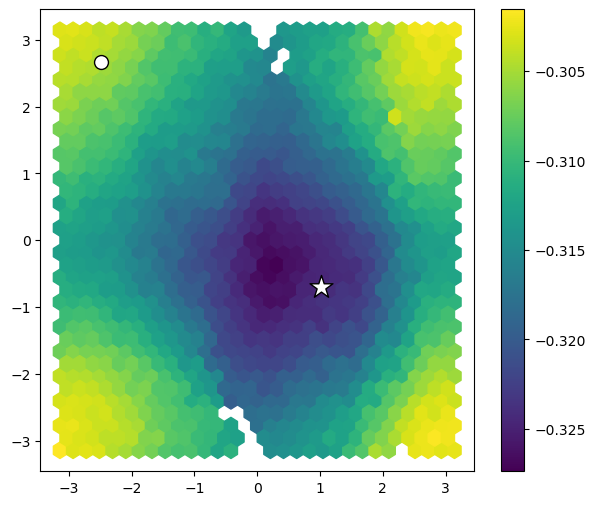

In [34]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1)
hb = ax.hexbin(
    phi_list, psi_list, C=cv[:, 0],  # data
    gridsize=30,                     # controls resolution
    reduce_C_function=np.mean,       # compute average per hexagon
    cmap='viridis',                  # colormap
    extent=[-np.pi, np.pi, -np.pi, np.pi]
)
verts = hb.get_offsets()
values = hb.get_array()
threshold = 0.1
mask = np.abs(values) < threshold
    
cbar = fig.colorbar(hb)
ax.scatter(phi_start, psi_start, edgecolors="black", c="w", zorder=101, s=100)
ax.scatter(phi_goal, psi_goal, edgecolors="black", c="w", zorder=101, s=300, marker="*")

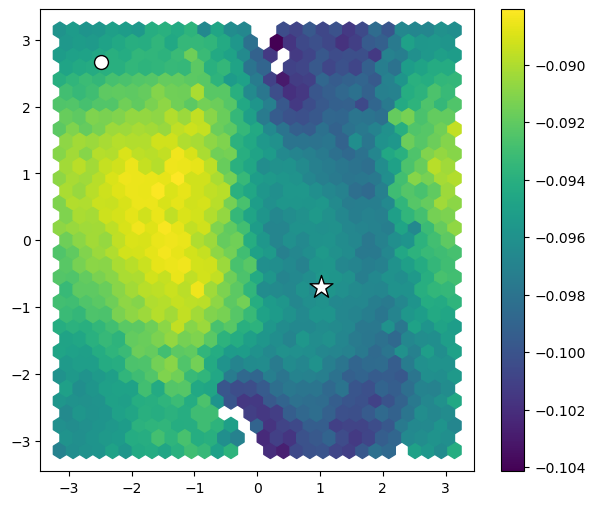

In [35]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1)
hb = ax.hexbin(
    phi_list, psi_list, C=cv[:, 1],  # data
    gridsize=30,                     # controls resolution
    reduce_C_function=np.mean,       # compute average per hexagon
    cmap='viridis',                  # colormap
    extent=[-np.pi, np.pi, -np.pi, np.pi]
)
verts = hb.get_offsets()
values = hb.get_array()
threshold = 0.1
mask = np.abs(values) < threshold
    
cbar = fig.colorbar(hb)
ax.scatter(phi_start, psi_start, edgecolors="black", c="w", zorder=101, s=100)
ax.scatter(phi_goal, psi_goal, edgecolors="black", c="w", zorder=101, s=300, marker="*")